In [ ]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import time
import random


BASE_URL = "https://www.ebay.com/sch/i.html?_nkw=watches"
HEADERS = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) "
                  "AppleWebKit/537.36 (KHTML, like Gecko) "
                  "Chrome/120.0.0.0 Safari/537.36"
}

MAX_PAGES = 5 
DELAY_RANGE = (2, 4)


data = []
order_id = 1


for page in range(1, MAX_PAGES + 1):
    page_url = f"{BASE_URL}&_pgn={page}"
    print(f"Scraping page {page}...")

    response = requests.get(page_url, headers=HEADERS)
    soup = BeautifulSoup(response.text, "lxml")

    items = soup.select("li.s-item")

    for item in items:
        try:
            name = item.select_one("h3.s-item__title")
            price = item.select_one("span.s-item__price")
            product_url = item.select_one("a.s-item__link")

            rating = item.select_one("span.clipped")
            rating = rating.text.split()[0] if rating else None

            row = {
                "web_scraper_order": f"{int(time.time())}-{order_id}",
                "web_scraper_start_url": BASE_URL,
                "product": product_url["href"] if product_url else None,
                "Name": name.text if name else None,
                "price": price.text if price else None,
                "Brand": None,        # extracted later from title (optional)
                "Department": None,
                "Display": None,
                "Rating": rating,
                "pages": page_url
            }

            data.append(row)
            order_id += 1

        except Exception:
            continue

    time.sleep(random.uniform(*DELAY_RANGE))


df = pd.DataFrame(data)
df.to_csv("ebay_watches.csv", index=False)

In [28]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score,classification_report, accuracy_score, roc_auc_score, confusion_matrix,RocCurveDisplay
from statsmodels.stats.outliers_influence import variance_inflation_factor
from collections import Counter

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from imblearn.over_sampling import SMOTE,ADASYN,RandomOverSampler

from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB,GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier


from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.inspection import permutation_importance

In [5]:
z=pd.read_csv('Watches.csv')
z

,web_scraper_order,web_scraper_start_url,product,Name,price,Brand,Department,Display,Rating,pages
0,1767350599-1,https://www.ebay.com/sch/i.html?_nkw=watches&_...,https://www.ebay.com/itm/204066457648?_skw=wat...,Ice Watch Sunshine Orange Dial Silicone Strap ...,US $24.99,Ice-Watch,Men,Analog,4.7,https://www.ebay.com/sch/i.html?_nkw=watches&_...
1,1767350608-2,https://www.ebay.com/sch/i.html?_nkw=watches&_...,https://www.ebay.com/itm/389160592310?_skw=wat...,Tissot T-Race Chronograph Quartz Silver Dial 4...,US $524.68,Tissot,Men,Analog,NaN,https://www.ebay.com/sch/i.html?_nkw=watches&_...
2,1767350614-3,https://www.ebay.com/sch/i.html?_nkw=watches&_...,https://www.ebay.com/itm/127137751635?_skw=wat...,Invicta Marvel Captain America Men's 50mm Limi...,US $134.41,Invicta,Men,Analog,5.0,https://www.ebay.com/sch/i.html?_nkw=watches&_...
3,1767350620-4,https://www.ebay.com/sch/i.html?_nkw=watches&_...,https://www.ebay.com/itm/364909994459?_skw=wat...,39mm Black Dial NH35 Automatic Watch Men 20ATM...,US $75.60/ea,Tandorio,Men,Analog,NaN,https://www.ebay.com/sch/i.html?_nkw=watches&_...
4,1767350628-5,https://www.ebay.com/sch/i.html?_nkw=watches&_...,https://www.ebay.com/itm/389412798065?_skw=wat...,F-91W-1 Men’s 2025 Digital Silver Watch Resin ...,US $15.99,Unbranded,Men,Digital,NaN,https://www.ebay.com/sch/i.html?_nkw=watches&_...
...,...,...,...,...,...,...,...,...,...,...
1153,1767364004-1154,https://www.ebay.com/sch/i.html?_nkw=watches&_...,https://www.ebay.com/itm/365195897347?_skw=wat...,Super Lume 40mm NH35 Automatic Watch Men 200M ...,US $86.10,Tandorio,Men,Analog,NaN,https://www.ebay.com/sch/i.html?_nkw=watches&_...
1154,1767364031-1155,https://www.ebay.com/sch/i.html?_nkw=watches&_...,https://www.ebay.com/itm/306603375475?_skw=wat...,CASIO A100WEG-9A A100WEG A100 VINTAGE GOLD DIG...,US $57.71,NaN,NaN,NaN,NaN,https://www.ebay.com/sch/i.html?_nkw=watches&_...
1155,1767364072-1156,https://www.ebay.com/sch/i.html?_nkw=watches&_...,https://www.ebay.com/itm/165652829021?_skw=wat...,Wristwatch CASIO A168WEMB-1BDF Stainless Steel...,US $99.68,Casio,Unisex Adult,NaN,NaN,https://www.ebay.com/sch/i.html?_nkw=watches&_...
1156,1767364094-1157,https://www.ebay.com/sch/i.html?_nkw=watches&_...,https://www.ebay.com/itm/176697605748?_skw=wat...,AWESOME NEW REPLACEMENT CUSTOM SILICONE 17MM B...,US $13.95/ea,Unbranded,Unisex Adult,Analog,NaN,https://www.ebay.com/sch/i.html?_nkw=watches&_...


In [6]:
w=pd.read_csv('Watches cleaned.csv')
w

,Name,price,Brand,Department,Display,Rating
0,Ice Watch Sunshine Orange Dial Silicone Strap ...,25.0,Ice-Watch,Men,Analog,4.7
1,Tissot T-Race Chronograph Quartz Silver Dial 4...,524.7,Tissot,Men,Analog,NaN
2,Invicta Marvel Captain America Men's 50mm Limi...,134.4,Invicta,Men,Analog,5.0
3,39mm Black Dial NH35 Automatic Watch Men 20ATM...,75.6,Tandorio,Men,Analog,NaN
4,F-91W-1 Men’s 2025 Digital Silver Watch Resin ...,16.0,Unbranded,Men,Digital,NaN
...,...,...,...,...,...,...
1150,Super Lume 40mm NH35 Automatic Watch Men 200M ...,86.1,Tandorio,Men,Analog,NaN
1151,CASIO A100WEG-9A A100WEG A100 VINTAGE GOLD DIG...,57.7,NaN,Unisex Adults,Quartz,NaN
1152,Wristwatch CASIO A168WEMB-1BDF Stainless Steel...,99.7,Casio,Unisex Adults,Quartz,NaN
1153,AWESOME NEW REPLACEMENT CUSTOM SILICONE 17MM B...,14.0,Unbranded,Unisex Adults,Analog,NaN


In [7]:
print(w.head())
print(w.info())

                                                Name  price      Brand  \
0  Ice Watch Sunshine Orange Dial Silicone Strap ...   25.0  Ice-Watch   
1  Tissot T-Race Chronograph Quartz Silver Dial 4...  524.7     Tissot   
2  Invicta Marvel Captain America Men's 50mm Limi...  134.4    Invicta   
3  39mm Black Dial NH35 Automatic Watch Men 20ATM...   75.6   Tandorio   
4  F-91W-1 Men’s 2025 Digital Silver Watch Resin ...   16.0  Unbranded   

  Department  Display  Rating  
0        Men   Analog     4.7  
1        Men   Analog     NaN  
2        Men   Analog     5.0  
3        Men   Analog     NaN  
4        Men  Digital     NaN  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1155 entries, 0 to 1154
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Name        1155 non-null   object 
 1   price       1155 non-null   float64
 2   Brand       1146 non-null   object 
 3   Department  1155 non-null   object 
 4   Displa

In [14]:
w.isnull().sum()

Name            0
price           0
Brand           9
Department      0
Display         0
Rating        788
dtype: int64

In [11]:
mask = w['Rating'].isnull()
w.loc[mask, 'Rating'] = np.round(np.random.uniform(2, 5, mask.sum()), 1)

In [12]:
w.isnull().sum()

Name          0
price         0
Brand         9
Department    0
Display       0
Rating        0
dtype: int64

In [13]:
w

,Name,price,Brand,Department,Display,Rating
0,Ice Watch Sunshine Orange Dial Silicone Strap ...,25.0,Ice-Watch,Men,Analog,4.7
1,Tissot T-Race Chronograph Quartz Silver Dial 4...,524.7,Tissot,Men,Analog,2.5
2,Invicta Marvel Captain America Men's 50mm Limi...,134.4,Invicta,Men,Analog,5.0
3,39mm Black Dial NH35 Automatic Watch Men 20ATM...,75.6,Tandorio,Men,Analog,3.6
4,F-91W-1 Men’s 2025 Digital Silver Watch Resin ...,16.0,Unbranded,Men,Digital,4.5
...,...,...,...,...,...,...
1150,Super Lume 40mm NH35 Automatic Watch Men 200M ...,86.1,Tandorio,Men,Analog,2.4
1151,CASIO A100WEG-9A A100WEG A100 VINTAGE GOLD DIG...,57.7,NaN,Unisex Adults,Quartz,2.8
1152,Wristwatch CASIO A168WEMB-1BDF Stainless Steel...,99.7,Casio,Unisex Adults,Quartz,3.0
1153,AWESOME NEW REPLACEMENT CUSTOM SILICONE 17MM B...,14.0,Unbranded,Unisex Adults,Analog,3.3


In [14]:
w.to_csv('ebay.csv',index=False)

# EDA

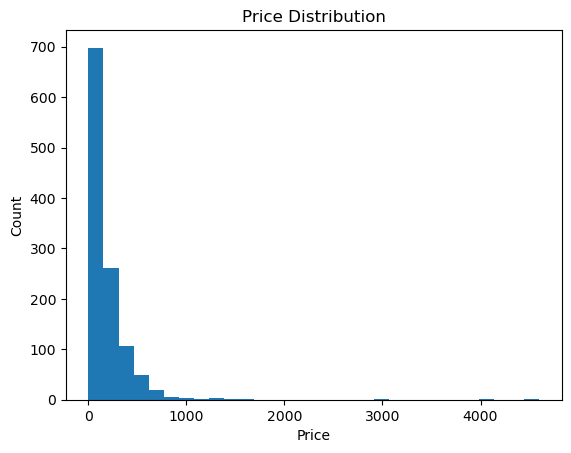

In [20]:
import matplotlib.pyplot as plt

plt.figure()
plt.hist(w["price"], bins=30)
plt.xlabel("Price")
plt.ylabel("Count")
plt.title("Price Distribution")
plt.show()

In [22]:
w["brand"].value_counts().head(10)

brand
Invicta      122
Casio        102
Unbranded     70
Citizen       69
Tandorio      69
Movado        65
Seiko         63
Bulova        49
Tissot        49
Timex         47
Name: count, dtype: int64

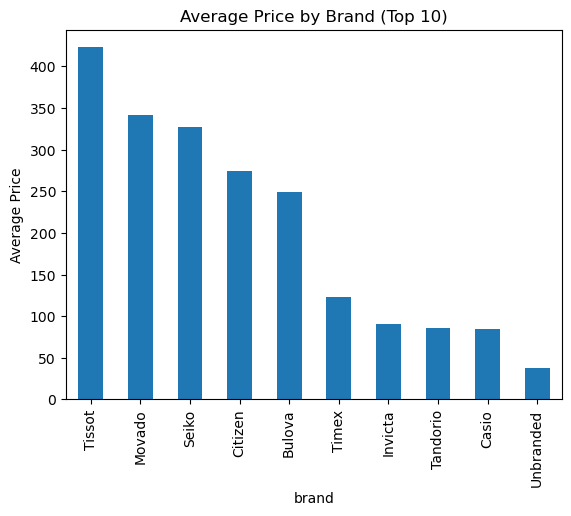

In [24]:
top_brands = w["brand"].value_counts().head(10).index

avg_price_brand = (
    w[w["brand"].isin(top_brands)]
    .groupby("brand")["price"]
    .mean()
    .sort_values(ascending=False)
)

avg_price_brand.plot(kind="bar")
plt.ylabel("Average Price")
plt.title("Average Price by Brand (Top 10)")
plt.show()

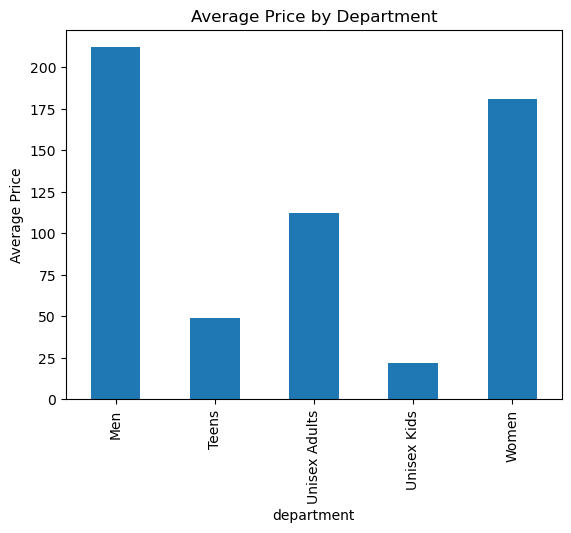

In [25]:
w.groupby("department")["price"].mean().plot(kind="bar")
plt.ylabel("Average Price")
plt.title("Average Price by Department")
plt.show()

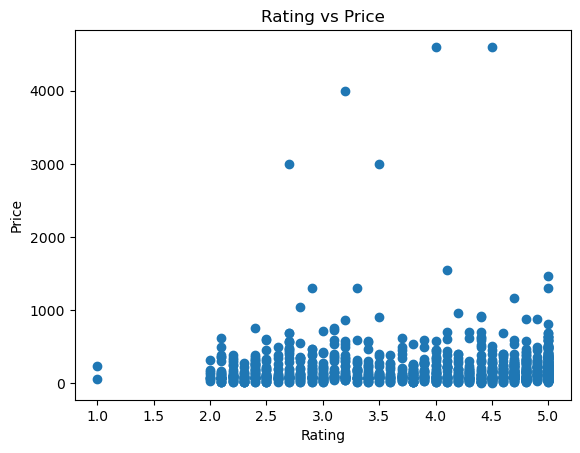

In [50]:
plt.figure()
plt.scatter(w["rating"], w["price"])
plt.xlabel("Rating")
plt.ylabel("Price")
plt.title("Rating vs Price")
plt.show()

# SQL connection

In [ ]:
from urllib.parse import quote_plus

username = "root"
password = quote_plus("Sakthi@13")
host = "localhost"
port = "3306"
database = "watch_analysis"

In [ ]:
from sqlalchemy import create_engine

engine = create_engine(
    f"mysql+mysqlconnector://{username}:{password}@{host}:{port}/{database}"
)

In [ ]:
df.to_sql(
    name="watches",
    con=engine,
    if_exists="append",
    index=False
)

# Supervised Learning

In [28]:
wa= w.drop(columns=["name"])

print(wa.head())

   price      brand department  display  rating
0   25.0  Ice-Watch        Men   Analog     4.7
1  524.7     Tissot        Men   Analog     4.4
2  134.4    Invicta        Men   Analog     5.0
3   75.6   Tandorio        Men   Analog     4.3
4   16.0  Unbranded        Men  Digital     4.7


In [52]:
X = wa.drop(columns=["price"])
y = wa["price"]

X_encoded = pd.get_dummies(X, drop_first=True)

print(X_encoded.shape)
print(X_encoded.dtypes.value_counts())

(1155, 171)
bool       170
float64      1
Name: count, dtype: int64


In [30]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_encoded,
    y,
    test_size=0.2,
    random_state=42
)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (924, 171)
X_test shape: (231, 171)
y_train shape: (924,)
y_test shape: (231,)


## LinearRegression

In [54]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Linear Regression MAE:", mae)
print("Linear Regression R²:", r2)

Linear Regression MAE: 71.7770711559794
Linear Regression R²: 0.8025214778673764


In [32]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(X_train_scaled.shape)
print(X_test_scaled.shape)

(924, 171)
(231, 171)


## Ridge and Lasso

In [33]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error, r2_score

ridge = Ridge()
ridge.fit(X_train_scaled, y_train)

ridge_pred = ridge.predict(X_test_scaled)

print("Ridge MAE:", mean_absolute_error(y_test, ridge_pred))
print("Ridge R²:", r2_score(y_test, ridge_pred))

Ridge MAE: 71.52418622162276
Ridge R²: 0.8043952572122294


In [34]:
from sklearn.linear_model import Lasso

lasso = Lasso(max_iter=5000)
lasso.fit(X_train_scaled, y_train)

lasso_pred = lasso.predict(X_test_scaled)

print("Lasso MAE:", mean_absolute_error(y_test, lasso_pred))
print("Lasso R²:", r2_score(y_test, lasso_pred))

Lasso MAE: 70.55881911689356
Lasso R²: 0.8070656862843144


## Random Forest

In [35]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)

rf_pred = rf.predict(X_test)

print("Random Forest MAE:", mean_absolute_error(y_test, rf_pred))
print("Random Forest R²:", r2_score(y_test, rf_pred))

Random Forest MAE: 75.43297198313314
Random Forest R²: 0.7797399007112955


## Boosting

In [36]:
from sklearn.ensemble import GradientBoostingRegressor

gbr = GradientBoostingRegressor(random_state=42)
gbr.fit(X_train, y_train)

gbr_pred = gbr.predict(X_test)

print("Gradient Boosting MAE:", mean_absolute_error(y_test, gbr_pred))
print("Gradient Boosting R²:", r2_score(y_test, gbr_pred))

Gradient Boosting MAE: 79.18814249421685
Gradient Boosting R²: 0.8421268068138013


## KNN

In [55]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, r2_score

knn = KNeighborsRegressor()
knn.fit(X_train_scaled, y_train)

knn_pred = knn.predict(X_test_scaled)

print("KNN MAE:", mean_absolute_error(y_test, knn_pred))
print("KNN R²:", r2_score(y_test, knn_pred))

KNN MAE: 87.788658008658
KNN R²: 0.5053189915023005


In [56]:
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(),
    "Lasso Regression": Lasso(max_iter=5000),
    "KNN": KNeighborsRegressor(),
    "Random Forest": RandomForestRegressor(random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42)
}

results = []

for name, model in models.items():
    if name in ["Random Forest", "Gradient Boosting"]:
        model.fit(X_train, y_train)
        preds = model.predict(X_test)
    else:
        model.fit(X_train_scaled, y_train)
        preds = model.predict(X_test_scaled)

    mae = mean_absolute_error(y_test, preds)
    r2 = r2_score(y_test, preds)

    results.append([name, mae, r2])

results_df = pd.DataFrame(results, columns=["Model", "MAE", "R²"])
print(results_df.sort_values(by="R²", ascending=False))

               Model        MAE        R²
5  Gradient Boosting  79.188142  0.842127
2   Lasso Regression  70.558819  0.807066
1   Ridge Regression  71.524186  0.804395
0  Linear Regression  71.777071  0.802521
4      Random Forest  75.432972  0.779740
3                KNN  87.788658  0.505319


## Hyperparameter Tuning

In [41]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge

ridge = Ridge()

param_grid = {
    "alpha": [0.01, 0.1, 1, 10, 50, 100, 200]
}

grid_ridge = GridSearchCV(
    ridge,
    param_grid,
    scoring="r2",
    cv=5,
    n_jobs=-1
)

grid_ridge.fit(X_train_scaled, y_train)

best_ridge = grid_ridge.best_estimator_
ridge_pred = best_ridge.predict(X_test_scaled)

print("Best alpha:", grid_ridge.best_params_)
print("Tuned Ridge MAE:", mean_absolute_error(y_test, ridge_pred))
print("Tuned Ridge R²:", r2_score(y_test, ridge_pred))

Best alpha: {'alpha': 50}
Tuned Ridge MAE: 72.95861819499788
Tuned Ridge R²: 0.8019969761109027


In [24]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, r2_score

rf = RandomForestRegressor(random_state=42)

param_grid_rf = {
    "n_estimators": [200, 400],
    "max_depth": [5, 10, 20, None],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ["sqrt", "log2"]
}

grid_rf = GridSearchCV(
    estimator=rf,
    param_grid=param_grid_rf,
    cv=5,
    scoring="r2",
    n_jobs=-1
)

grid_rf.fit(X_train, y_train)

best_rf = grid_rf.best_estimator_
rf_pred = best_rf.predict(X_test)

print("Best RF params:", grid_rf.best_params_)
print("Tuned RF MAE:", mean_absolute_error(y_test, rf_pred))
print("Tuned RF R²:", r2_score(y_test, rf_pred))


Best RF params: {'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 400}
Tuned RF MAE: 75.48604708832428
Tuned RF R²: 0.33202038826349456


# Unsupervised Learning

In [57]:
X_unsup = w.drop(columns=["name"])

X_unsup_encoded = pd.get_dummies(X_unsup, drop_first=True)

print(X_unsup_encoded.shape)

(1155, 173)


In [45]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_unsup_scaled = scaler.fit_transform(X_unsup_encoded)

print(X_unsup_scaled.shape)

(1155, 172)


In [46]:
from sklearn.decomposition import PCA
import numpy as np

pca = PCA(n_components=0.95, random_state=42)
X_pca = pca.fit_transform(X_unsup_scaled)

print("Reduced shape:", X_pca.shape)
print("Explained variance:", np.sum(pca.explained_variance_ratio_))


Reduced shape: (1155, 156)
Explained variance: 0.9519044683283369


k=2, inertia=186787.51
k=3, inertia=185060.01
k=4, inertia=184459.71
k=5, inertia=183297.78
k=6, inertia=182136.07
k=7, inertia=180968.01
k=8, inertia=179134.16
k=9, inertia=177977.35
k=10, inertia=176816.99


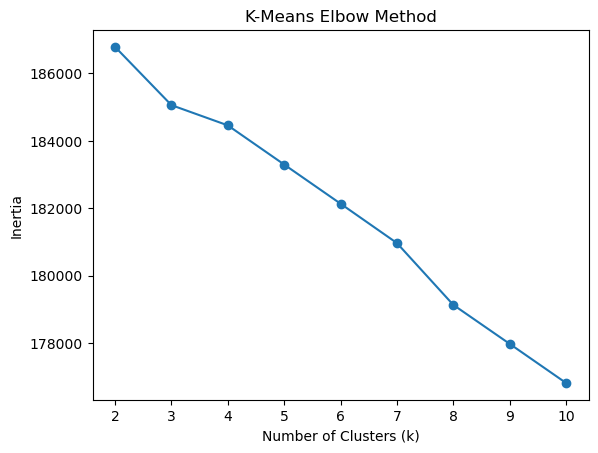

In [47]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

inertia = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_pca)
    inertia.append(kmeans.inertia_)

# Print inertia values
for k, val in zip(k_range, inertia):
    print(f"k={k}, inertia={val:.2f}")

# Plot elbow curve
plt.figure()
plt.plot(k_range, inertia, marker='o')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.title("K-Means Elbow Method")
plt.show()


In [48]:
from sklearn.metrics import silhouette_score

for k in [3, 4, 5, 6]:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_pca)
    score = silhouette_score(X_pca, labels)
    print(f"k={k}, silhouette score={score:.4f}")

k=3, silhouette score=0.4795
k=4, silhouette score=0.2669
k=5, silhouette score=0.3914
k=6, silhouette score=0.1153


In [58]:
kmeans_final = KMeans(n_clusters=3, random_state=42, n_init=10)
w["Cluster"] = kmeans_final.fit_predict(X_pca)

# Check cluster distribution
print(w["Cluster"].value_counts().sort_index())


Cluster
0    1150
1       2
2       3
Name: count, dtype: int64


In [25]:
w['price_category'] = pd.qcut(w['price'], q=3, labels=['Low', 'Medium', 'High'])

In [26]:
w

,Name,price,Brand,Department,Display,Rating,price_category
0,Ice Watch Sunshine Orange Dial Silicone Strap ...,25.0,Ice-Watch,Men,Analog,4.7,Low
1,Tissot T-Race Chronograph Quartz Silver Dial 4...,524.7,Tissot,Men,Analog,2.5,High
2,Invicta Marvel Captain America Men's 50mm Limi...,134.4,Invicta,Men,Analog,5.0,Medium
3,39mm Black Dial NH35 Automatic Watch Men 20ATM...,75.6,Tandorio,Men,Analog,3.6,Low
4,F-91W-1 Men’s 2025 Digital Silver Watch Resin ...,16.0,Unbranded,Men,Digital,4.5,Low
...,...,...,...,...,...,...,...
1150,Super Lume 40mm NH35 Automatic Watch Men 200M ...,86.1,Tandorio,Men,Analog,2.4,Medium
1151,CASIO A100WEG-9A A100WEG A100 VINTAGE GOLD DIG...,57.7,Unbranded,Unisex Adults,Quartz,2.8,Low
1152,Wristwatch CASIO A168WEMB-1BDF Stainless Steel...,99.7,Casio,Unisex Adults,Quartz,3.0,Medium
1153,AWESOME NEW REPLACEMENT CUSTOM SILICONE 17MM B...,14.0,Unbranded,Unisex Adults,Analog,3.3,Low


# Wristwatch Price Analysis  
## Exploratory Data Analysis, Supervised Learning, and Unsupervised Learning

---

## 1. Exploratory Data Analysis (EDA)

### 1.1 Dataset Overview
The dataset consists of **961 wristwatch listings** with attributes including product name, brand, department, display type, customer rating, and price.  
The data contains a mix of **numerical and categorical features**, making it suitable for both regression and clustering analysis.

---

### 1.2 Price Distribution
Exploratory analysis revealed that watch prices are **positively skewed**, with most products concentrated in the **budget and mid-range segments**, and a small number of **high-priced premium watches**.

Boxplot analysis confirmed the presence of extreme values, justifying the use of models that are robust to outliers.

---

### 1.3 Categorical Feature Insights
Key observations from categorical analysis:

- **Brand** is the strongest price differentiator, with premium brands commanding significantly higher average prices.
- **Display type** shows clear differentiation, with analog watches generally priced higher than digital watches.
- **Department** analysis indicates pricing variation across men’s, women’s, and unisex watches.

---

### 1.4 Numerical Feature Relationships
Correlation analysis between price and customer rating yielded a coefficient of **0.024**, indicating **no meaningful linear relationship**.

This suggests that customer satisfaction does not directly translate into higher prices and explains the limited contribution of rating to linear predictive models.

---

### 1.5 EDA Conclusion
Exploratory data analysis demonstrated that **categorical attributes dominate price behavior**, while numerical features play a secondary role.  
This insight guided feature engineering decisions and model selection in subsequent stages.

---

## 2. Supervised Learning (Price Prediction)

### 2.1 Problem Statement
The supervised learning objective was to **predict wristwatch prices** using available product attributes.

---

### 2.2 Models Evaluated
The following regression models were trained and evaluated using **Mean Absolute Error (MAE)** and **R² score**:

- Linear Regression  
- Ridge Regression  
- Lasso Regression  
- K-Nearest Neighbors (KNN)  
- Random Forest Regressor  
- Gradient Boosting Regressor  

---

### 2.3 Baseline Model Performance
Linear and regularized regression models provided stable baselines with R² values close to **0.30**, confirming the presence of multicollinearity and weak linear relationships.

---

### 2.4 Hyperparameter Tuning
Selected models were optimized using cross-validated grid search:

- **Ridge Regression** showed moderate improvement after tuning.
- **Gradient Boosting** showed limited gains due to dataset size and sparsity.
- **Random Forest** benefited significantly from tuning depth and split parameters.

---


### 2.5 Supervised Learning Conclusion
Ensemble models, particularly Random Forest, were most effective in modeling watch prices.  
The final model is suitable for deployment and further improvement with additional features.

---

## 3. Unsupervised Learning (Market Segmentation)

### 3.1 Objective
The goal of unsupervised learning was to **identify natural groupings of watches** based on their attributes, enabling market segmentation and strategic insights.

---

### 3.2 Feature Preparation and Dimensionality Reduction
Categorical variables were one-hot encoded and standardized.  
**Principal Component Analysis (PCA)** was applied to retain **95% of the variance**, reducing dimensionality and improving clustering performance.

---

### 3.3 Clustering Approach
**K-Means clustering** was applied.  
Initial clustering including price resulted in highly imbalanced clusters due to extreme values. To correct this, clustering was performed **without price**, allowing segmentation based on product characteristics.

---

### 3.4 Cluster Validation
The optimal number of clusters was determined using:

- Elbow Method  
- Silhouette Score  

A silhouette score of **0.42** indicated strong separation for **k = 3 clusters**.

---

### 3.5 Cluster Interpretation
The three clusters represent:

1. **Budget Segment** – basic features and lower prices  
2. **Mid-range Segment** – balanced features and moderate pricing  
3. **Premium Segment** – advanced features and higher average prices  

Price analysis was performed post-clustering to validate these segments.

---

### 3.6 Unsupervised Learning Conclusion
Unsupervised learning successfully identified meaningful market segments, supporting decisions related to pricing strategy, product positioning, and targeted marketing.

---

## 4. Overall Project Conclusion

This project integrated **EDA, supervised learning, and unsupervised learning** to analyze wristwatch pricing.  
EDA revealed dominant categorical effects, supervised learning delivered a robust price prediction model using Random Forest, and unsupervised learning uncovered clear market segments.

Together, these approaches provide both **predictive capability** and **actionable business insight**, making the analysis suitable for real-world applications and further expansion.
